In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mutual_info_score
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

from scipy.special import kl_div

In [2]:
ood_df = pd.read_csv('/users/lucelo/UQLRM/metadata_vpo.tsv', sep='\t', header=0)

In [3]:
ood_df.head()

,Preference,RewardScoreMean,RewardScoreVar,Model,Dataset,id
0,chosen,0.217773,0.474215,vpo,train,0
1,chosen,-1.054688,0.461424,vpo,train,1
2,chosen,-0.306641,0.450735,vpo,train,2
3,chosen,-1.054688,0.461424,vpo,train,3
4,chosen,-1.054688,0.461424,vpo,train,4


<Axes: >

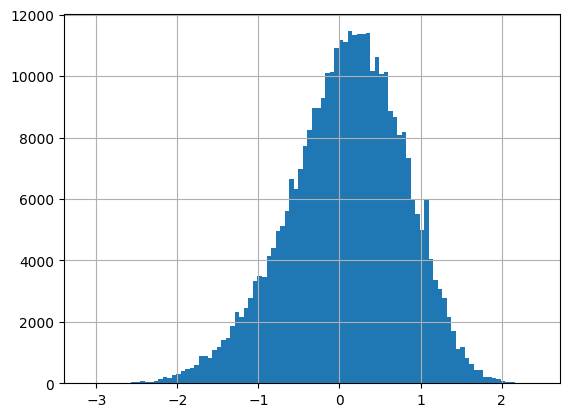

In [4]:
ood_df['RewardScoreMean'].hist(bins=100)

Text(0.5, 1.0, 'Chosen/Rejected - VPO')

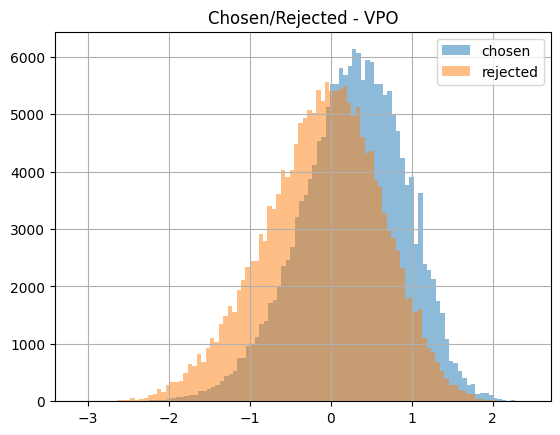

In [5]:
ood_df[ood_df['Preference'] == 'chosen']['RewardScoreMean'].hist(bins=100, alpha=0.5, label='chosen')
ood_df[ood_df['Preference'] == 'rejected']['RewardScoreMean'].hist(bins=100, alpha=0.5, label='rejected')
plt.legend()
plt.title("Chosen/Rejected - VPO")

/scratch-ssd/lucelo/conda_envs/uqrm/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Reward Scores - VPO')

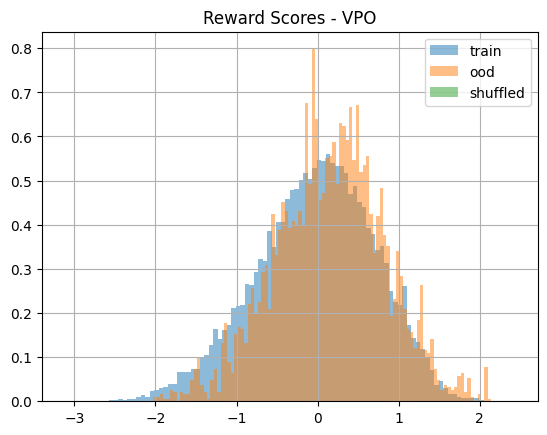

In [6]:
ood_df[ood_df['Dataset'] == 'train']['RewardScoreMean'].hist(bins=100, alpha=0.5, label='train', density=True)
ood_df[ood_df['Dataset'] == 'ood']['RewardScoreMean'].hist(bins=100, alpha=0.5, label='ood', density=True)
ood_df[ood_df['Dataset'] == 'shuffled']['RewardScoreMean'].hist(bins=100, alpha=0.5, label='shuffled', density=True)
plt.legend()
plt.title("Reward Scores - VPO")

Text(0.5, 1.0, 'Reward Uncertainties - VPO')

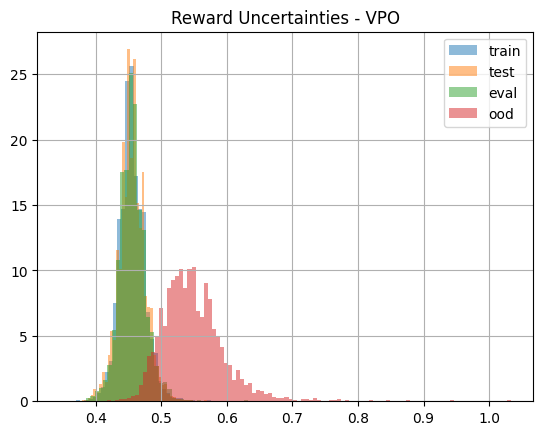

In [15]:
ood_df[ood_df['Dataset'] == 'train']['RewardScoreVar'].hist(bins=100, alpha=0.5, label='train', density=True)
ood_df[ood_df['Dataset'] == 'test']['RewardScoreVar'].hist(bins=100, alpha=0.5, label='test', density=True)
ood_df[ood_df['Dataset'] == 'eval']['RewardScoreVar'].hist(bins=100, alpha=0.5, label='eval', density=True)
ood_df[ood_df['Dataset'] == 'ood']['RewardScoreVar'].hist(bins=100, alpha=0.5, label='ood', density=True)
# ood_df[ood_df['Dataset'] == 'shuffled']['RewardScoreVar'].hist(bins=100, alpha=0.5, label='shuffled', density=True)
plt.legend()
plt.title("Reward Uncertainties - VPO")

In [8]:
chosen_df = ood_df[ood_df['Preference'] == 'chosen'].rename(columns={'RewardScoreMean': 'RewardChosenMean', 'RewardScoreVar': 'RewardChosenVar'})
rejected_df = ood_df[ood_df['Preference'] == 'rejected'].rename(columns={'RewardScoreMean': 'RewardRejectedMean', 'RewardScoreVar': 'RewardRejectedVar'})
merged_df = chosen_df.merge(rejected_df, on=['id', 'Dataset'], how='inner')
merged_df['RewardDiff'] = merged_df['RewardChosenMean'] - merged_df['RewardRejectedMean']
merged_df['PreferenceProb'] = sigmoid(merged_df['RewardDiff'])
merged_df

,Preference_x,RewardChosenMean,RewardChosenVar,Model_x,Dataset,id,Preference_y,RewardRejectedMean,RewardRejectedVar,Model_y,RewardDiff,PreferenceProb
0,chosen,0.217773,0.474215,vpo,train,0,rejected,-0.398438,0.459625,vpo,0.616211,0.649356
1,chosen,-1.054688,0.461424,vpo,train,1,rejected,0.122070,0.474215,vpo,-1.176758,0.235636
2,chosen,-0.306641,0.450735,vpo,train,2,rejected,-0.314453,0.457833,vpo,0.007812,0.501953
3,chosen,-1.054688,0.461424,vpo,train,3,rejected,-0.445312,0.447228,vpo,-0.609375,0.352202
4,chosen,-1.054688,0.461424,vpo,train,4,rejected,-0.453125,0.454270,vpo,-0.601562,0.353986
...,...,...,...,...,...,...,...,...,...,...,...,...
178939,chosen,1.000000,0.558762,vpo,ood,2279,rejected,1.367188,0.567561,vpo,-0.367188,0.409221
178940,chosen,0.960938,0.550099,vpo,ood,2280,rejected,0.373047,0.535261,vpo,0.587891,0.642881
178941,chosen,0.490234,0.529025,vpo,ood,2281,rejected,-0.106934,0.508759,vpo,0.597168,0.645008
178942,chosen,0.490234,0.529025,vpo,ood,2282,rejected,0.241211,0.514756,vpo,0.249023,0.561936


In [9]:
def compute_rw_diff_var(x):
    chosen_mu = x['RewardChosenMean']
    chosen_var = x['RewardChosenVar']
    chosen_points = np.random.normal(chosen_mu, np.sqrt(chosen_var), 10000)

    rejected_mu = x['RewardRejectedMean']
    rejected_var = x['RewardRejectedVar']
    rejected_points = np.random.normal(rejected_mu, np.sqrt(rejected_var), 10000)

    diff = chosen_points - rejected_points
    return pd.Series([np.mean(diff), np.var(diff)])

In [10]:
merged_df[['RwDiffMean','RwDiffVar']] = merged_df.apply(lambda x: compute_rw_diff_var(x), axis=1)

In [11]:
merged_df.head()

,Preference_x,RewardChosenMean,RewardChosenVar,Model_x,Dataset,id,Preference_y,RewardRejectedMean,RewardRejectedVar,Model_y,RewardDiff,PreferenceProb,RwDiffMean,RwDiffVar
0,chosen,0.217773,0.474215,vpo,train,0,rejected,-0.398438,0.459625,vpo,0.616211,0.649356,0.626243,0.936869
1,chosen,-1.054688,0.461424,vpo,train,1,rejected,0.122070,0.474215,vpo,-1.176758,0.235636,-1.190293,0.946931
2,chosen,-0.306641,0.450735,vpo,train,2,rejected,-0.314453,0.457833,vpo,0.007812,0.501953,0.004398,0.910415
3,chosen,-1.054688,0.461424,vpo,train,3,rejected,-0.445312,0.447228,vpo,-0.609375,0.352202,-0.623882,0.890155
4,chosen,-1.054688,0.461424,vpo,train,4,rejected,-0.453125,0.454270,vpo,-0.601562,0.353986,-0.607819,0.921744


In [12]:
train_df = merged_df[merged_df['Dataset'] == 'train'][['RewardRejectedVar', 'RewardChosenVar', 'PreferenceProb', 'RewardDiff', 'RwDiffMean', 'RwDiffVar']]
train_df['GT'] = 1.0
train_df['Error'] = (train_df['RwDiffMean'] < 0) * 1.0
train_df['AveragedPreferenceProb'] = sigmoid(train_df['RwDiffMean'])
train_df['CrossEntropy'] = kl_div(train_df['GT'], train_df['AveragedPreferenceProb'])

In [13]:
train_df.head()

,RewardRejectedVar,RewardChosenVar,PreferenceProb,RewardDiff,RwDiffMean,RwDiffVar,GT,Error,AveragedPreferenceProb,CrossEntropy
0,0.459625,0.474215,0.649356,0.616211,0.626243,0.936869,1.0,0.0,0.651637,0.079905
1,0.474215,0.461424,0.235636,-1.176758,-1.190293,0.946931,1.0,1.0,0.233207,0.689037
2,0.457833,0.450735,0.501953,0.007812,0.004398,0.910415,1.0,0.0,0.501100,0.192050
3,0.447228,0.461424,0.352202,-0.609375,-0.623882,0.890155,1.0,1.0,0.348899,0.401872
4,0.454270,0.461424,0.353986,-0.601562,-0.607819,0.921744,1.0,1.0,0.352557,0.395100


In [14]:
from scipy import stats
print(f"Correlation Between Var(r1) + Var(r2) and Cross Entropy for Training: {stats.spearmanr(train_df['RwDiffVar'], train_df['CrossEntropy'])[0]}")

Correlation Between Var(r1) + Var(r2) and Cross Entropy for Training: -0.06884392758517609
